In [31]:
import os
import random
from pathlib import Path
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup

def randomness_controller(mSeed):
    # Set seed for Python's built-in random module
    random.seed(mSeed)
    # Set seed for NumPy
    np.random.seed(mSeed)
    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(mSeed)
    # Set seed for GPU
    torch.cuda.manual_seed_all(mSeed)
    # For deterministic results(not set)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
randomness_controller(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGE_SIZE = 224

Intro on:
Critirea
Baseline
Dataset

In [32]:
class CustomImageDataset(Dataset):
    def __init__(self, df, label_col='EXP', transform=None):
        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, self.label_col]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None  # or handle as needed
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
#Workers random Seeding    
def worker_init_fn(worker_id):
    seed = SEED + worker_id  # Set unique seed for each worker
    np.random.seed(seed)
    random.seed(seed)


Golden Test set
Test size: 279
         Image  EXP  ICM  TE                             image_path
0  0004_03.png    2    1   1  Blastocyst_Dataset/Images/0004_03.png
1  0005_08.png    3    0   0  Blastocyst_Dataset/Images/0005_08.png
2  0008_01.png    2    0   0  Blastocyst_Dataset/Images/0008_01.png
3  0011_02.png    0    3   3  Blastocyst_Dataset/Images/0011_02.png
4  0011_03.png    3    1   0  Blastocyst_Dataset/Images/0011_03.png

Label Counts:
   EXP  ICM   TE
0   23  144  117
1   31   65   79
2   85   16   29
3  135   54   54
4    5    0    0
Showing samples for EXP


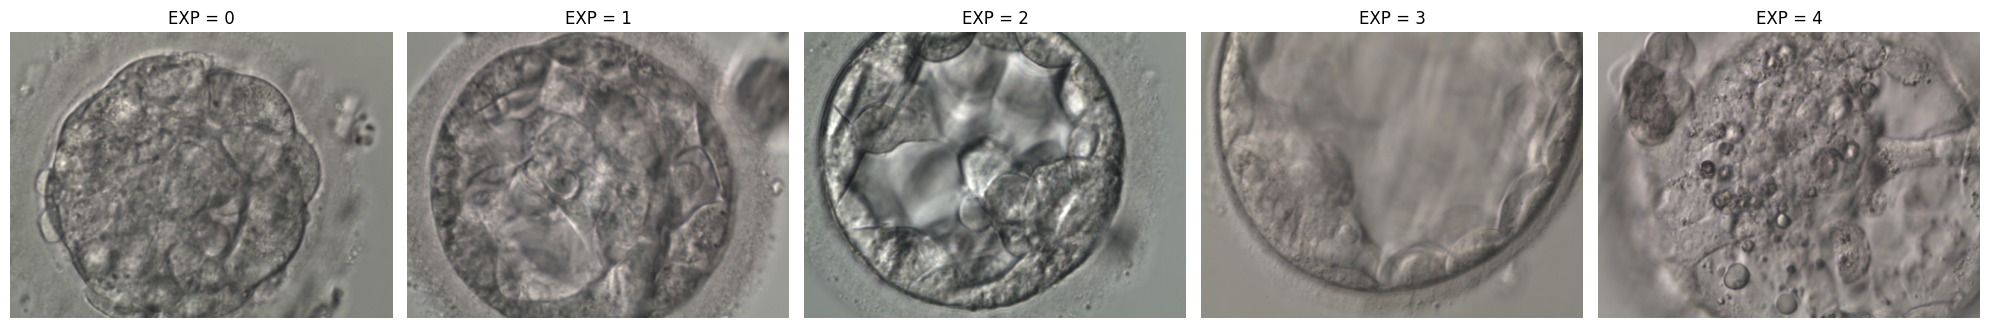

Showing samples for ICM


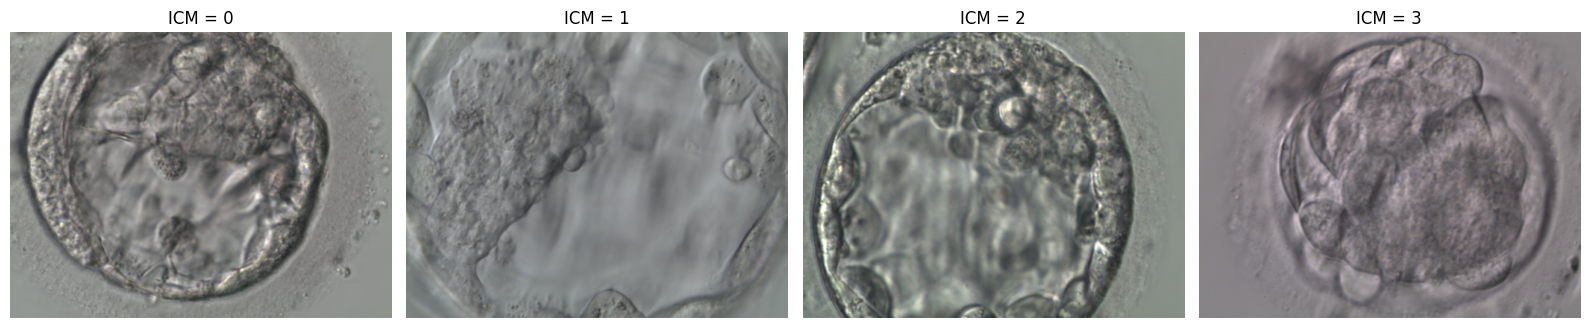

Showing samples for TE


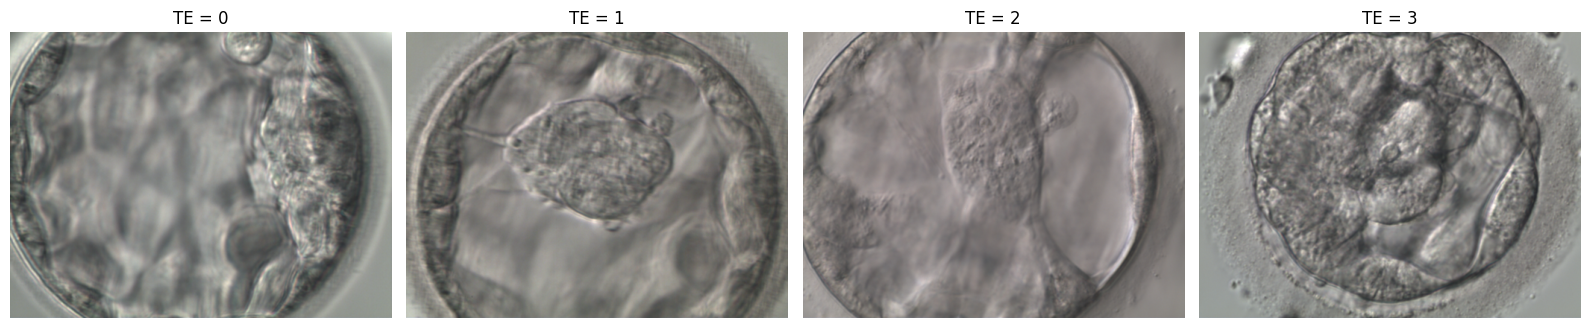

In [36]:

test_csv_path =  Path("Blastocyst_Dataset/Gardner_test_gold_onlyGardnerScores.csv")
image_dir = Path("Blastocyst_Dataset/Images")

# Load Golden train data and creat dataset
test_df = pd.read_csv(test_csv_path, delimiter=';',na_values=["NA"])
test_df['image_path'] = test_df['Image'].apply(lambda x: image_dir / x)
test_df = test_df.drop(columns=['Unnamed: 4'])# drop empty column 
test_df = test_df.rename(columns={
    'EXP_gold': 'EXP',
    'ICM_gold': 'ICM',
    'TE_gold': 'TE'
})
test_df['EXP'] = test_df['EXP'].replace("ND", np.nan)
test_df['ICM'] = test_df['ICM'].replace("ND", 3)
test_df['TE'] = test_df['TE'].replace("ND", 3)
test_df.dropna(inplace=True)
test_df['EXP'] = test_df['EXP'].astype(int)
test_df['ICM'] = test_df['ICM'].astype(int)
test_df['TE'] = test_df['TE'].astype(int)

EXP_test_dataset = CustomImageDataset(test_df, transform=val_transforms,label_col='EXP')
EXP_test_loader = DataLoader(EXP_test_dataset, batch_size=BATCH_SIZE, shuffle=False,worker_init_fn = worker_init_fn,num_workers=6,prefetch_factor=2,pin_memory=True)
ICM_test_dataset = CustomImageDataset(test_df, transform=val_transforms,label_col='ICM')
ICM_test_loader = DataLoader(ICM_test_dataset, batch_size=BATCH_SIZE, shuffle=False,worker_init_fn = worker_init_fn,num_workers=6,prefetch_factor=2,pin_memory=True)
TE_test_dataset = CustomImageDataset(test_df, transform=val_transforms,label_col='TE')
TE_test_loader = DataLoader(TE_test_dataset, batch_size=BATCH_SIZE, shuffle=False,worker_init_fn = worker_init_fn,num_workers=6,prefetch_factor=2,pin_memory=True)

print("\nGolden Test set")
print(f"Test size: {len(test_df)}")
print(test_df.head())
label_counts = pd.DataFrame({ 
    'EXP': test_df['EXP'].value_counts(), 
    'ICM': test_df['ICM'].value_counts(), 
    'TE': test_df['TE'].value_counts()
}).fillna(0).sort_index()
label_counts = label_counts.astype(int)
print("\nLabel Counts:")
print(label_counts)

labels = {
    'EXP': range(5),  # 0-4
    'ICM': range(4),  # 0-3
    'TE': range(4)    # 0-3
}

for column, label_vals in labels.items():
    print(f"Showing samples for {column}")

    # Plot all images for each label side by side
    fig, axs = plt.subplots(1, len(label_vals), figsize=(len(label_vals)*4, 4))

    for label, ax in zip(label_vals, axs):
        row = test_df[test_df[column] == label].sample(1)
        image_file = row.iloc[0]['image_path']

        image = mpimg.imread(image_file)

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"{column} = {label}")

    plt.tight_layout()
    plt.show()


SWIN Model
Optimiser
Scheduler
Model Parameters
Training

SWIN Model Presentation
Optimal Parametes and observations
Results

In [45]:
def test(model,test_loader= EXP_test_loader,device = device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
            

    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:  
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            total += outputs.size(0)
            correct += preds.eq(labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    # Flatten the list of labels and predictions
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    print(f"\nValidation Results — Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [47]:
model_name = "swin_base_patch4_window7_224"
model = timm.create_model(model_name, pretrained=True, num_classes=5,drop_path_rate = 0.7)
checkpoint = torch.load('Real/EXP/EXP_acc_84.56375838926175.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

test(model)



Validation Results — Loss: 0.5048, Accuracy: 84.23%
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88        23
           1       0.67      0.58      0.62        31
           2       0.81      0.76      0.79        85
           3       0.89      0.96      0.93       135
           4       0.50      0.60      0.55         5

    accuracy                           0.84       279
   macro avg       0.76      0.75      0.75       279
weighted avg       0.84      0.84      0.84       279

Confusion Matrix:
[[ 19   4   0   0   0]
 [  1  18  12   0   0]
 [  0   5  65  14   1]
 [  0   0   3 130   2]
 [  0   0   0   2   3]]


GUN Model
+++++

GUN Model Presentation

SWIN Model with synthetic data pressentation
Results

Final Observations